This notebook optimizes the size of the pv modules for each house, such that it has an optimal size of the pv module. Optimal is in this case that the cost over a specific time period minimizes. Therefore we consider a finite timespan. We simulate a single year and then multiply the import costs from the grid and rewards, that we get from the grid company, by the number of years.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.grid import Grid
import random
from ipywidgets import IntProgress
from IPython.display import display
%matplotlib inline

### Import datasets
We only choose a single house here for the consumption, while we keep all possibilities of pv modules. We also retrieve the sizes of the pv modules from the production DataFrame.

In [2]:
# Consumption data
df_cons = pd.read_csv('data/consumption_ausgrid.csv')
df_cons['Unnamed: 0'] = pd.to_datetime(df_cons['Unnamed: 0'])
df_cons = df_cons.set_index('Unnamed: 0')
df_cons_red = df_cons.iloc[:,0]
# Production data
df_prod = pd.read_csv('data/normalized_generation_ausgrid_025steps.csv')
df_prod['Unnamed: 0'] = pd.to_datetime(df_prod['Unnamed: 0'])
df_prod = df_prod.set_index('Unnamed: 0')

In [3]:
# Retrieve data from consumption
data_consumption = df_cons_red.values

# Retrieve data from production and pv_sizes
data_production = df_prod.values
pv_peakpowers = [float(key) for key in df_prod.keys()]

# Single Household
### Create a grid model 
This creates a standard grid model, which does not include any storage device (i.e. one storage with zero capacity). Therefore we get the pure consumption data and the price for this consumption. 

In [4]:
g = Grid(num_houses=1,num_storages=1,max_capacity=0,num_pvtypes=len(pv_peakpowers),pv_peakpower=pv_peakpowers)
g.set_costs() # Set standard costs
res_dict = g.simulate(data_cons=data_consumption,data_prod=data_production)
print(res_dict)

{'import_grid_kwh': 7679.200999999989, 'export_grid_kwh': 0.0, 'pv_production_kwh': 0.0, 'setup_cost_storage': 0, 'setup_cost_pv': 0.0, 'cost_import_grid': 1919.8002499999973, 'reward_export_grid': 0.0}


###  Objective function 
We now need to define an objective function, that we want to optimize. As outlined before we want to optimize here the cost within a certain time frame (e.g. 7 years). Setting up storages and PV systems are one time expenses, so we just leave them as they result from the model simulation. However the costs and reward from grid interactions are only valid for a single year. Hence we multiply them by the number of years, which we look at, to get an approximation for the total costs.
We can also think of completly different objective functions, such as minimizing the interaction with the grid. Or combinations of costs and grid dependency factors.

In [5]:
def objective_function(res_dict,years=7):
    total_cost = res_dict["setup_cost_storage"] + res_dict["setup_cost_pv"]
    total_cost += res_dict["cost_import_grid"]*years
    total_cost -= res_dict["reward_export_grid"]*years
    return total_cost

Applying the objective function to the model without a PV installation, gives us simply the normal cost for energy in the house over the defined timespan.

In [6]:
total_cost_noPV = objective_function(res_dict)
print(total_cost_noPV)

13438.601749999982


Applying the objective function now to the grid model for all possible PV types gives us a "cost-landscape".


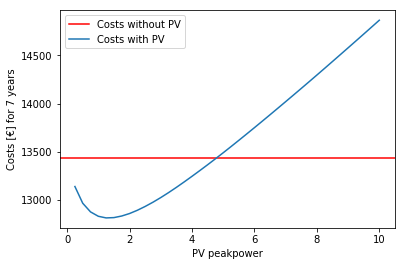

In [7]:
total_costs = []
# For all possible PV types
for i in range(data_production.shape[1]):
    # Set pv type of house to this specific one
    g.change_pvtype(num_house=0,pv_type=i)
    # Simulate the grid for one year
    res_dict = g.simulate(data_cons=data_consumption,data_prod=data_production)
    # Objective function
    total_costs.append(objective_function(res_dict))
    
# Plot the total costs agains the peakpower of the used module
plt.axhline(total_cost_noPV,c='r',label='Costs without PV')
plt.xlabel('PV peakpower')
plt.ylabel('Costs [€] for 7 years')
plt.plot(pv_peakpowers,total_costs,label='Costs with PV')
plt.legend()
plt.savefig('plots/single_household_7year.png',dpi=200)

The downside of this specific objective function is, that it depends on the timespan. If the timespan is too large (e.g. 15 years), the total cost only decreases with the peakpower of the installed pv module. Hence the largest module is the best. 
Otherwise, if the timespan is too small, the costs only increase with peakpower and no pv module is the cheapest choice.

# Multiple households
Now we are going to do the same as above just for multiple households that all have different consumption schedules. In order to cut down the dimensions we need to use later on we only take the first 20 PV modules as available. These correspond to sizes from $0.25$ kWp to $5.00$ kWp

In [8]:
# Choose number of houses houses
num_houses = 5
data_consumption = df_cons.iloc[:,:num_houses].values

# Retrieve data from production and pv_sizes
df_prod = df_prod.iloc[:,0:20]
data_production = df_prod.values
pv_peakpowers = [float(key) for key in df_prod.keys()]

# Create the grid model and simulate one year
g = Grid(num_houses=num_houses,num_storages=1,max_capacity=0,num_pvtypes=len(pv_peakpowers),pv_peakpower=pv_peakpowers)
# Set standard costs
g.set_costs()

Now we randomize the attached pv module to each house and simulate for one year.

In [9]:
g.randomize()
res_dict = g.simulate(data_cons=data_consumption,data_prod=data_production)
print(res_dict)

{'import_grid_kwh': 22405.888250000233, 'export_grid_kwh': 11918.947249999948, 'pv_production_kwh': 15951.254999999815, 'setup_cost_storage': 0, 'setup_cost_pv': 14350.0, 'cost_import_grid': 5601.472062500058, 'reward_export_grid': 1191.8947249999949}


Now this it the point, where we can start implementing a **genetic algorithm** to optimize the size of the pv module attached to each house. Since all houses do not interact (YET!) we could also simply optimize each house on its own and would result in the optimal solution. However the houses will interact through the storage systems later and we can not optimize each house on its own anymore. Thus we already build the genetic algorithm here. 

First we initialize a starting population of grids and randomize their initial states.

In [10]:
num_population = 100
population = []
total_costs = np.array([])
for i in range(num_population):
    # Create Grid, set costs, randomize and simulate
    g = Grid(num_houses=num_houses,num_storages=1,max_capacity=0,num_pvtypes=len(pv_peakpowers),pv_peakpower=pv_peakpowers)
    g.set_costs()
    g.randomize()
    res_dict = g.simulate(data_consumption,data_production)
    # Append grid to population and total costs to array
    population.append(g)
    total_costs = np.append(total_costs,objective_function(res_dict)) 

Now we need to create crossovers and mutations. We cut down to the original population size and start again. 

In [11]:
# Rates of crossover and mutation
mutation_rate = 0.5
crossover_rate = 0.5

# Storage arrays
num_generations = 20
mean_total_costs = np.zeros(num_generations)
std_total_costs = np.zeros(num_generations)
min_total_costs = np.zeros(num_generations)

# Progress bar
f = IntProgress(min=0, max=num_generations-1) # instantiate the bar
display(f) # display the bar

for i in range(num_generations): 
    # Mutations
    for k in range(int(mutation_rate*num_population)): 
        idx = random.randint(0,len(population)-1)
        g = population[idx].get_copy()
        g.mutate(storage_connection=False,pv_type=True)
        res_dict = g.simulate(data_consumption,data_production)
        population.append(g)
        total_costs = np.append(total_costs,objective_function(res_dict))
    
    # Crossover
    for k in range(int(crossover_rate*num_population)):
        idx1 = random.randint(0,len(population)-1)
        idx2 = random.randint(0,len(population)-1)
        g1 = population[idx1].get_copy()
        g2 = population[idx2].get_copy()
        g2 = g1.crossover(g2,storage_connection=False,pv_type=True)
        population.append(g1)
        population.append(g2)
        res_dict = g1.simulate(data_consumption,data_production)
        total_costs = np.append(total_costs,objective_function(res_dict))
        res_dict = g2.simulate(data_consumption,data_production)
        total_costs = np.append(total_costs,objective_function(res_dict))
        
    # Size reduction
    del_idx = np.argsort(total_costs)[num_population:]
    for idx in sorted(del_idx,reverse=True):
        population.pop(idx)
    total_costs = np.delete(total_costs,del_idx)
    
    # Calculate mean and min total costs
    mean_total_costs[i] = np.mean(total_costs)
    std_total_costs[i] = np.std(total_costs)
    min_total_costs[i] = np.min(total_costs)
    
    # Update value of the proress bar
    f.value = i

# Store the best grid individual
best_grid = population[np.argmin(total_costs)]
min_cost_genetic = np.min(min_total_costs)

IntProgress(value=0, max=20)

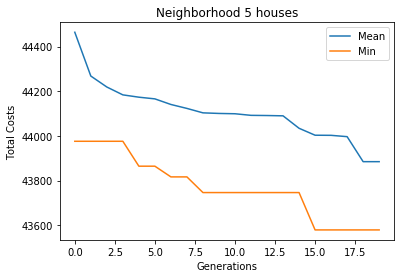

In [12]:
plt.ylabel('Total Costs')
plt.xlabel('Generations')
plt.plot(mean_total_costs,label='Mean')
plt.plot(min_total_costs,label='Min')
plt.title('Neighborhood ' + str(num_houses) + ' houses')
plt.legend()
plt.savefig('plots/' + str(num_houses) + '_household_onlyPV.png')

As we already stated above we can also optimize the cost for each house seperately. To check the results of the genetic algorithm above, we do the seperate optimization, which gives us the true result.

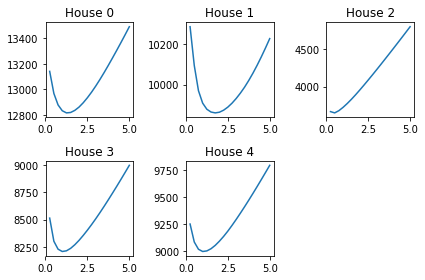

Minimum cost: 43534.36377500013
Genetic algorithm minimum: 43579.274812500225


In [14]:
min_sum = 0

for l in range(num_houses):
    data_consumption = df_cons.iloc[:,l].values
    g = Grid(num_houses=1,num_storages=1,max_capacity=0,num_pvtypes=len(pv_peakpowers),pv_peakpower=pv_peakpowers)
    g.set_costs()
    total_costs = []
    # For all possible PV types
    for i in range(data_production.shape[1]):
        # Set pv type of house to this specific one
        g.change_pvtype(num_house=0,pv_type=i)
        # Simulate the grid for one year
        res_dict = g.simulate(data_cons=data_consumption,data_prod=data_production)
        # Objective function
        total_costs.append(objective_function(res_dict))
    plt.subplot(2,3,l+1)
    plt.plot(pv_peakpowers,total_costs)
    plt.title('House ' + str(l))
    min_sum += np.min(total_costs)
plt.tight_layout()
plt.show()
print('Minimum cost: ' + str(min_sum))
print('Genetic algorithm minimum: ' + str(min_cost_genetic))

As we can see the minimum cost calculated manually is close to the optimal cost, calculated with the genetic algorithm. But the run of the genetic algorithm takes a huge computational amount.

A next step might be adding a grid system with storages. Hence we would have optimized the size of the pv systems first and then checked if a grid system is feasible. We can also think of doing both a the same time which takes even more computational power, but might result in a better/cheaper solution of the energy cost problem.